In [1]:
import keras
import h5py as h5
import numpy as np

PATH_DATA = 'F:/DlHackaton/HACKATHON/hackathon_small/data/train/eightieth.h5'
PATH_PREDICT_WITHOUT_GT = 'F:/DlHackaton/HACKATHON/hackathon_small/data/pred_students/pred_eighties_from_half_1_without_gt.h5'
PATH_SUBMIT = 'F:/DlHackaton/HACKATHON/hackathon_small/data/submit/pred_eighties_from_half_1_AWESOMEGROUP.h5'
PATH_PREDICT_WITH_GT = 'F:/DlHackaton/HACKATHON/hackathon_small/data/pred_teachers/pred_eighties_from_half_1.h5'

Using TensorFlow backend.


In [2]:
BATCH_SIZE = 32
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout
import keras.layers.normalization 
from keras.callbacks import Callback
%load_ext autoreload
%autoreload 2

In [3]:
def get_idxs(h5_path):
    f = h5.File(h5_path)
    return range(len(f['S2']))

def shuffle_idx(sample_idxs):
    return list(np.random.permutation(sample_idxs))

def split_train_val(sample_idxs, proportion):
    n_samples = len(sample_idxs)
    return sample_idxs[:int((1.-proportion)*n_samples)], sample_idxs[int((1.-proportion)*n_samples):]

def get_batch_count(idxs, batch_size):
    batch_count = int(len(idxs)//batch_size)
    remained_samples = len(idxs)%batch_size
    if remained_samples > 0:
        batch_count += 1

    return batch_count

In [4]:
def generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True : 
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X = f['S2'][batch_idxs, :,:,:]
            Y = f['TOP_LANDCOVER'][batch_idxs, :]
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), 23)

In [5]:
idxs = get_idxs(PATH_DATA)
shuffled_idxs = shuffle_idx(idxs)
train_idxs, val_idxs = split_train_val(shuffled_idxs, 0.2)

In [6]:
train_gen = generator(PATH_DATA, BATCH_SIZE, train_idxs)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen = generator(PATH_DATA, BATCH_SIZE, val_idxs)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)

In [7]:
print(train_batch_count, val_batch_count)

5850 1463


In [8]:
model = Sequential()
model.add(BatchNormalization(input_shape=(16, 16, 4)))

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(23, activation='softmax'))


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 16, 16, 4)         16        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        1184      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               295040    
__________

# FIT

In [10]:
from math import floor

# optim = keras.optimizers.Adam(lr=0.001)
optim = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(train_gen, steps_per_epoch=floor(train_batch_count / BATCH_SIZE ), epochs=10, verbose=1, validation_data=val_gen, validation_steps= floor(val_batch_count / BATCH_SIZE ))

Epoch 1/10
182/182 [==============================] - 24s - loss: 1.5354 - acc: 0.4688 - val_loss: 1.6513 - val_acc: 0.3819
Epoch 2/10
182/182 [==============================] - 9s - loss: 1.3240 - acc: 0.5103 - val_loss: 1.2299 - val_acc: 0.5694
Epoch 3/10
182/182 [==============================] - 9s - loss: 1.2912 - acc: 0.5223 - val_loss: 1.1626 - val_acc: 0.5597
Epoch 4/10
182/182 [==============================] - 9s - loss: 1.2388 - acc: 0.5412 - val_loss: 1.1866 - val_acc: 0.5514
Epoch 5/10
182/182 [==============================] - 9s - loss: 1.2490 - acc: 0.5347 - val_loss: 1.1563 - val_acc: 0.5535
Epoch 6/10
182/182 [==============================] - 9s - loss: 1.2466 - acc: 0.5381 - val_loss: 1.1783 - val_acc: 0.5417
Epoch 7/10
182/182 [==============================] - 10s - loss: 1.2227 - acc: 0.5404 - val_loss: 1.1949 - val_acc: 0.5507
Epoch 8/10
182/182 [==============================] - 9s - loss: 1.2062 - acc: 0.5426 - val_loss: 1.1485 - val_acc: 0.5646
Epoch 9/10
182

# Prediction

In [21]:
import os 
def prediction_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True : 
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X = f['S2'][batch_idxs, :,:,:]
            yield np.array(X)

def build_h5_pred_file(pred, h5_output_path):
    if os.path.exists(h5_output_path):
        os.remove(h5_output_path)
    f = h5.File(h5_output_path, 'w')
    top_landcover_submit = f.create_dataset("TOP_LANDCOVER", (len(pred), 1), maxshape=(None, 1))
    top_landcover_submit[:, 0] = pred
    f.close()
    
    return 1

In [22]:
pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
print(len(pred_idx))
pred_gen = prediction_generator(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
pred_batch_count = get_batch_count(pred_idx, BATCH_SIZE)
prediction = model.predict_generator(pred_gen, steps=pred_batch_count, verbose=1)



241700
7553/7554 [============================>.] - ETA: 0s

In [23]:
print(len(prediction))
build_h5_pred_file(np.argmax(prediction, axis = 1), PATH_SUBMIT)

241700


1

# Confusion Matrix

In [24]:
def gt_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        Y = f['TOP_LANDCOVER'][batch_idxs, :]
        yield keras.utils.np_utils.to_categorical(np.array(Y), 23)

gt_gen = gt_generator(PATH_PREDICT_WITH_GT, BATCH_SIZE, pred_idx)
gt = []
for elem in gt_gen:
    gt.append(elem)
gt = np.vstack(gt)

In [25]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=7)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure()

In [26]:
def clean_confusion_matrix(confusion_matrix, classes):
    real_classes = []
    for c in range(len(classes)):
        if np.sum(confusion_matrix[:,c])+np.sum(confusion_matrix[c, :]) != 0:
            real_classes.append(c)
    real_confusion_matrix = np.empty((len(real_classes), len(real_classes)))  
    for c_index in range(len(real_classes)):
        real_confusion_matrix[c_index,:] = confusion_matrix[real_classes[c_index], real_classes]
    return real_confusion_matrix, real_classes

Normalized confusion matrix


<IPython.core.display.Javascript object>


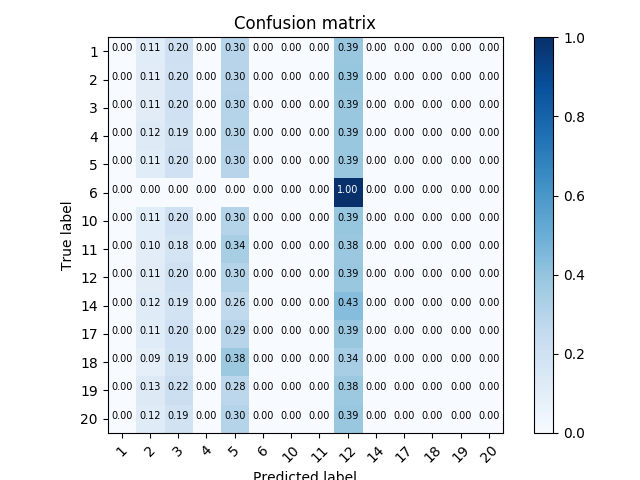

<IPython.core.display.Javascript object>


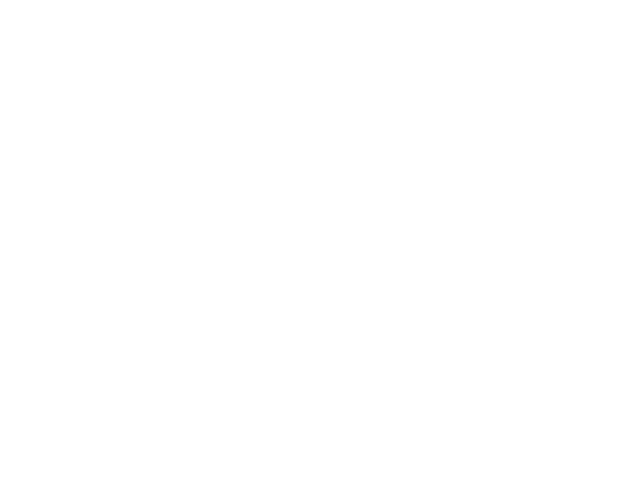

In [27]:
%matplotlib notebook
from sklearn.metrics import confusion_matrix
y_true = np.argmax(gt, axis=1)
y_pred = np.argmax(prediction, axis = 1)

real_cnf_matrix, real_classes = clean_confusion_matrix(confusion_matrix(y_true, y_pred, labels= range(23)), range(23))
plot_confusion_matrix(real_cnf_matrix, classes = real_classes, normalize=True)

# Evaluate 

In [37]:
test_idxs = get_idxs(PATH_PREDICT_WITH_GT)

test = generator(PATH_PREDICT_WITH_GT, BATCH_SIZE, test_idxs)
test_batch_count = get_batch_count(test_idxs, BATCH_SIZE)

In [38]:
score  = model.evaluate_generator(test, steps=pred_batch_count)

In [40]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.89926093162
Test accuracy: 0.318924286305
